In [ ]:
!pip install ninja
!pip install pickle5
!pip install wandb

In [3]:
#Import

import gdown
import pandas as pd
import cv2
import os
import numpy as np
import pickle
import wandb
import matplotlib.pyplot as plt

import logging

In [ ]:
# Clone repository

%cd /content/drive/MyDrive
!git clone https://github.com/NahidEbrahimian/Human-Parsing-on-Binary-Image


In [4]:
# Project directory

path = "/content/drive/MyDrive/Human-Parsing-on-Binary-Image"

In [ ]:
# Create directories

%cd Human-Parsing-on-Binary-Image
!mkdir weights
!mkdir input
!mkdir output 
!mkdir dataset
!mkdir pretrain_model

/content/drive/MyDrive/Human-Parsing-on-Binary-Image


In [ ]:
# Download resnet101 and pascal models


url = "https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE"
out ="weights/schp-pascal-person-part.pth"
gdown.download(url, out) 

url = "https://drive.google.com/uc?id=1-MGJP3ffp1OYEyirMx-l-uJ51k4Jlus9"
out ="pretrain_model/resnet101-imagenet.pth"
gdown.download(url, out) 

In [ ]:
# Clone dataset repository

%cd dataset
!git clone https://github.com/Healthcare-Robotics/bodies-at-rest

In [ ]:
# Download dataset

%cd bodies-at-rest/PressurePose
!chmod +x download_real.sh
!bash download_real.sh

In [ ]:
# Read iamges of all pickle files ans save as another pickle file


pickle_files = ["p_select.p", "prescribed.p"]
path = os.path.join(path, "/dataset/bodies-at-rest/data_BR/real")

list_of_files = os.listdir(path)
rgb_images = []

for file in list_of_files:
  for p_file in pickle_files:
    pickle_file = pd.read_pickle(os.path.join(path, file, p_file))
    for i in range(0, len(pickle_file['images'])):
      rgb = pickle_file['RGB'][i]
      rgb_images.append(rgb)


In [ ]:
path = os.path.join(path, "dataset")

with open(os.path.join(path, 'rgb_real_data.pkl'),'wb') as f:
    pickle.dump(rgb_images, f)

In [ ]:
%cd /content/drive/MyDrive/Human-Parsing-on-Binary-Image/dataset

!mkdir rgb_dataset
!mkdir segmented_output
!mkdir final_dataset

/content/drive/MyDrive/Human-Parsing-on-Binary-Image/dataset


In [ ]:
# Save images of pickle file as rgb images and contrast enhancement

pickle_file = pd.read_pickle(os.path.join(path, "dataset/rgb_real_data.pkl"))

alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

for im_num in range(0, len(pickle_file)):
    rgb = pickle_file[im_num]
    img_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)

    cv2.imwrite(os.path.join(path, f"dataset/rgb_dataset/{im_num}.jpg"), img_adjusted)


In [ ]:
# Running algorithm to segment images

%cd /content/drive/MyDrive/Human-Parsing-on-Binary-Image

!python simple_extractor.py --dataset 'pascal' --model-restore "weights/schp-pascal-person-part.pth" --input-dir 'dataset/rgb_dataset' --output-dir 'dataset/segmented_output'

/content/drive/MyDrive/Human-Parsing-on-Binary-Image
Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 1051/1051 [04:48<00:00,  3.65it/s]


In [4]:
# Make directories for final dataset

%cd /content/drive/MyDrive/Human-Parsing-on-Binary-Image/dataset/final_dataset

!mkdir train_images
!mkdir val_images
!mkdir train_segmentations
!mkdir val_segmentations
!mkdir test_images

!touch train_id.txt
!touch val_id.txt

/content/drive/MyDrive/Human-Parsing-on-Binary-Image/dataset/final_dataset


In [ ]:
# Convert segmented image to binary image and write text files

list_files = os.listdir(os.path.join(path, 'dataset/segmented_output'))
list_files.sort()

f1 = open(os.path.join(path, 'dataset/final_dataset/train_id.txt'), 'w')
f2 = open(os.path.join(path, 'dataset/final_dataset/val_id.txt'), 'w')

for i, im in enumerate(list_files):

  img = cv2.imread(os.path.join(path, 'dataset/segmented_output', im))
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray[img_gray > 0] = 255
  img_gray[img_gray == 0] = 0

  _, tail = os.path.split(im)
  name = tail.split('.')[0]

  if i < 5:
    cv2.imwrite(os.path.join(path, f"dataset/final_dataset/test_images/{name}.jpg"), img_gray)

  elif i > 5 and i < 750:
  # if i < 750:
    cv2.imwrite(os.path.join(path, f"dataset/final_dataset/train_images/{name}.jpg"), img_gray)
    f1.write(f"{name}")
    f1.write('\n')

  else:
    cv2.imwrite(os.path.join(path, f"dataset/final_dataset/val_images/{name}.jpg"), img_gray)
    f2.write(f"{name}")
    f2.write('\n')

f1.close()
f2.close()

In [11]:
# Create labels

list_files = os.listdir(os.path.join(path, 'dataset/segmented_output'))
list_files.sort()

for i, im in enumerate(list_files):

  img_rgb = cv2.imread(os.path.join(path, 'dataset/segmented_output', im))
  img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_gray[img_gray == 0] = 0
  img_gray[img_gray == 15] = 1
  img_gray[img_gray == 38] = 2
  img_gray[img_gray == 53] = 3
  img_gray[img_gray == 75] = 4
  img_gray[img_gray == 90] = 5
  img_gray[img_gray == 113] = 6

  _, tail = os.path.split(im)
  name = tail.split('.')[0]

  if i < 5:
    cv2.imwrite(os.path.join(path, f"dataset/final_dataset/test_images/{name}.png"), img_gray)

  elif i > 5 and i < 750:
  # if i < 750:
    cv2.imwrite(os.path.join(path, f"dataset/final_dataset/train_segmentations/{name}.png"), img_gray)
  else:
    cv2.imwrite(os.path.join(path, f"dataset/final_dataset/val_segmentations/{name}.png"), img_gray)

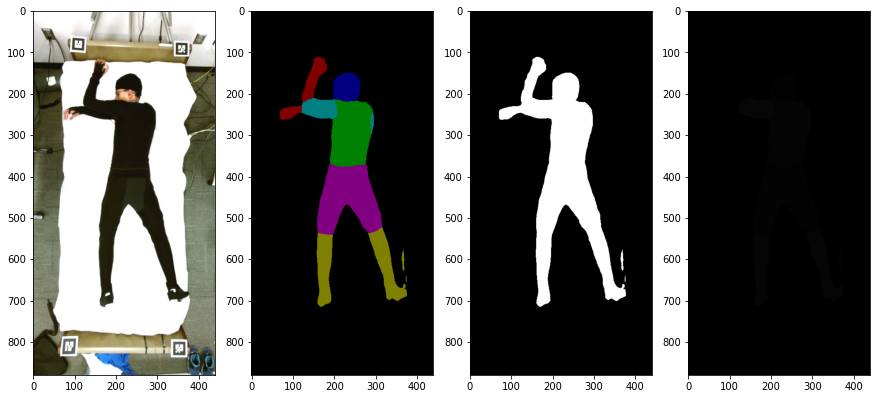

In [ ]:
# visualization

fig = plt.figure(figsize=(15, 15))

img = cv2.imread(os.path.join(path, "dataset/rgb_dataset/500.jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(141) 
plt.imshow(img)

img1 = cv2.imread(os.path.join(path, "dataset/segmented_output/500.png"))
plt.subplot(142) 
plt.imshow(img1)

img = cv2.imread(os.path.join(path, "dataset/final_dataset/train_imgaes/500.jpg"))
plt.subplot(143) 
plt.imshow(img, cmap='gray')

img = cv2.imread(os.path.join(path, "dataset/final_dataset/train_segmentations/500.png"))
plt.subplot(144) 
plt.imshow(img, cmap='gray')

In [ ]:
# Train

%cd /content/drive/MyDrive/Human-Parsing-on-Binary-Image

!python train.py --data-dir dataset/final_dataset --num-classes 7 --batch-size 3 --imagenet-pretrain pretrain_model/resnet101-imagenet.pth

In [7]:
%cd /content/drive/MyDrive/Human-Parsing-on-Binary-Image

!python simple_extractor.py --dataset 'pascal' --model-restore log/checkpoint_40.pth.tar --input-dir input --output-dir output

/content/drive/MyDrive/Human-Parsing-on-Binary-Image
Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 5/5 [00:01<00:00,  3.51it/s]
